In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
np.set_printoptions(precision=4, suppress=True)

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

In [4]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [5]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [7]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 One-hot 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [8]:
class TwoLayerNet:
    """
      A two-layer fully-connected neural network. The net has an input dimension of
      N, a hidden layer dimension of H, and performs classification over C classes.
    """

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        """
        가중치 초기화
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:
        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)
        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [9]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)


In [10]:
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [11]:
#v = mean_squared_error(y_data, y_data, axis=1)
#print(v)

* 그냥 초기값으로 계산해보기

In [12]:
x_train.shape, t_train.shape

((60000, 784), (60000, 10))

### 학습하기

* Hyperparameters

In [13]:
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

In [14]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

* Train the network !

In [15]:
# 1에폭당 반복 수
iter_per_epoch = max(train_size // batch_size, 1)
print('iter_per_epoch = {}//{}={}'.format(train_size, batch_size,iter_per_epoch))

iter_per_epoch = 60000//100=600


In [16]:
print('epoch\tloss\tacc_trn\tacc_test')
print('---------------------------------')
for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1 에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print('{}\t{:.3f}\t{:.3f}\t{:.3f}'.format(i, loss, train_acc, test_acc))
        

epoch	loss	acc_trn	acc_test
---------------------------------
0	2.288	0.112	0.114
600	1.020	0.784	0.791
1200	0.530	0.872	0.880
1800	0.269	0.896	0.899
2400	0.405	0.907	0.911
3000	0.232	0.914	0.915
3600	0.216	0.919	0.923
4200	0.330	0.923	0.926
4800	0.274	0.928	0.931
5400	0.314	0.931	0.932
6000	0.124	0.935	0.935
6600	0.150	0.937	0.939
7200	0.172	0.940	0.940
7800	0.199	0.943	0.942
8400	0.172	0.945	0.944
9000	0.156	0.947	0.947
9600	0.139	0.949	0.948


### 결과 그려보기 및 분석

Text(0, 0.5, 'loss')

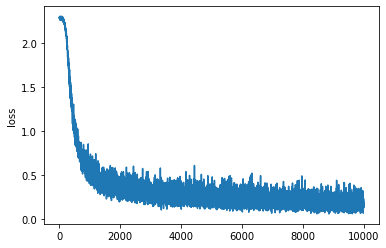

In [17]:
plt.plot(train_loss_list)
plt.ylabel('loss')

* Train accuracy

In [18]:
train_acc = network.accuracy(x_train, t_train)
print(train_acc)

0.9496333333333333


* Test accuracy

In [19]:
test_acc = network.accuracy(x_test, t_test)
print(test_acc)

0.9476


* 하나만 테스트해보기
: 그림 그리는 과정은 03_NeuralNetwork/01_3_NN_MNIST_Exploration.ipynb 을 참고해보세요

In [20]:
idx_to_test = 100 #바꾸어서 해보세요
x1 = x_test[idx_to_test]
t1 = t_test[idx_to_test]

In [21]:
x1.shape

(784,)

In [22]:
t1.shape

(10,)

In [23]:
title = '#{} {}'.format(np.argmax(t1), t1)
print(title)

#6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [24]:
img = x1.reshape((28,28))

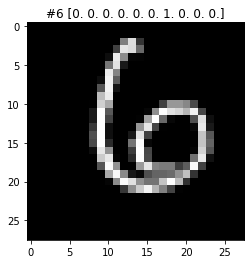

In [25]:
#plt.plot(img)
plt.imshow(img, cmap='gray')
plt.title(title)
plt.show()

In [26]:
y1 = network.predict(x1)

In [27]:
print(y1)

[0.0002 0.0006 0.0262 0.0001 0.0004 0.0003 0.9712 0.0001 0.0007 0.    ]


In [28]:
print(t1) # 정답
print(y1) # 학습된 neural network 가 구한 값. 

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0.0002 0.0006 0.0262 0.0001 0.0004 0.0003 0.9712 0.0001 0.0007 0.    ]


In [29]:
for i in range(10):
    print('#{}\t{}\t{:.3f}'.format(i, t1[i], y1[i]))

#0	0.0	0.000
#1	0.0	0.001
#2	0.0	0.026
#3	0.0	0.000
#4	0.0	0.000
#5	0.0	0.000
#6	1.0	0.971
#7	0.0	0.000
#8	0.0	0.001
#9	0.0	0.000


### TODO

* 위의 결과 논의해보기
* idx_to_test 바꾸어 테스트해보기

### References

* Stanford CS231n, Two-layer network <br>
https://cs231n.github.io/
https://github.com/yunjey/cs231n/blob/master/assignment1/cs231n/classifiers/neural_net.py

* 주교재 <br /> https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch04/train_neuralnet.py